In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [6]:
from scipy.optimize import curve_fit
def Gauss(x, A, mean, std):
  gauss = A*np.exp(-(x-mean)**2/(2*std**2))
  return gauss

In [86]:
filename = "Feb12_Amp147mV_st025us.txt_dig2-usb22575_CH1_20240212123313-11.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

#### SNR using peak height histogram

In [91]:
# Doing SNR using the peak noise method
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
    else:
        pass

peaks = np.array(peaks)
print(len(peaks))

79


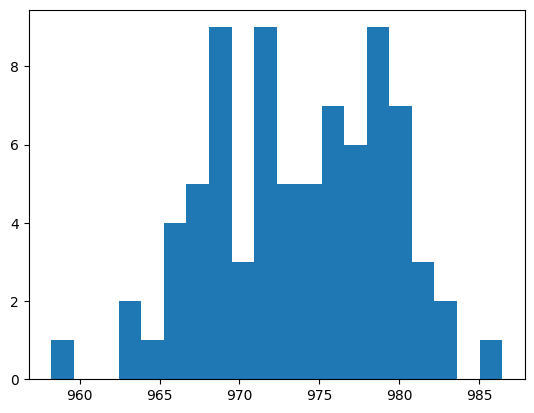

In [88]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [89]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[10, 970, 10])
print(popt)

[  7.31229186 973.38197713   6.43469772]


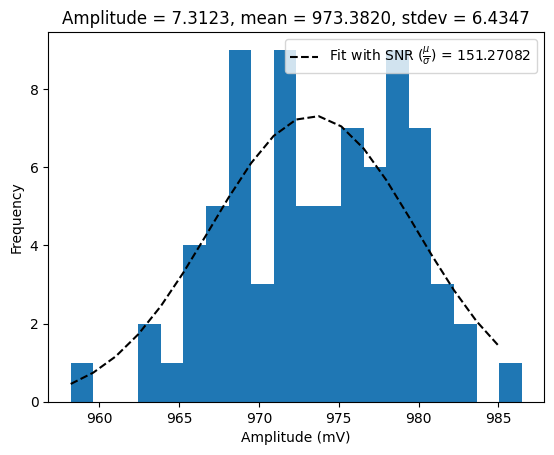

In [90]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Result logs for peak height SNR method:
1. SNR for input amplitude 68 mV and gain by shaper is 115.35387 with 20 bins and Gaussian fit.
2. SNR for input amplitude 68 mV is 81.19303 with 20 bins and Gaussian fit (base case).
3. SNR for input ampltude 147 mV is 151.27082 with 20 bins and Gaussian fit.

This seems to suggest that the bulk of the noise is coming from somewhere in between the function generator and the shaper. This is where the best improvement was seen: 81 $\rightarrow$ 151 

There seems to be some improvement when the shaper gain is increased. This could mean that some noise was picked up downstream of the shaper; thus, the result after adjusting shaper gain is a bit better. 

However, this is a *very, very* rough calculation with only about ~79-80 (1 min data collection) samples for each case. 

#### SNR using each trace

Just talked to Tsuguo about this method and we're not going to pursue this anymore since this method has less statistics than the previous one.

#### How to proceed

We've narrowed down the problem to in between the function generator and the shaper. Now I'm going to go downstream and change the stage-2 gain, ie the gain on the second op-amp.

The idea is that we make the gain higher and then observe the SNR. To this end, we swapped out the 2k resistor for a 5k one. Now, the second stage gain is (1 + $\frac{5000}{255}$ ~ 20.60)

In [117]:
filename = "Feb12_Amp68mV_st025us_2ndstagebaseline.txt_dig2-usb22575_CH1_20240212144230-20.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

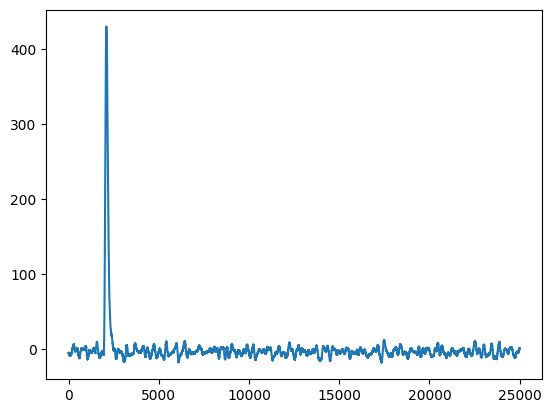

In [118]:
data = np.loadtxt(filename, skiprows=4, max_rows=1)
plt.plot(data)

In [119]:
# Doing SNR using the peak noise method
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
    else:
        pass

peaks = np.array(peaks)
print(len(peaks))

79


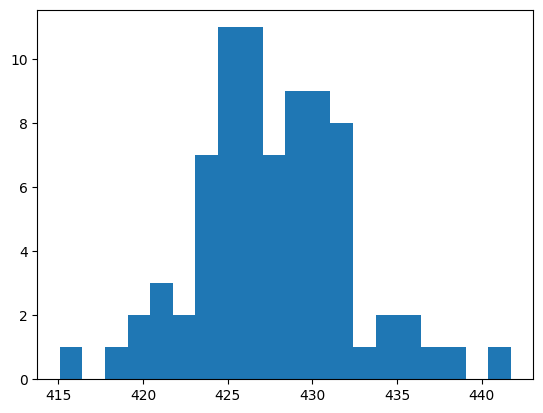

In [120]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [122]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[16, 430, 10])
print(popt)

[ 10.22780985 426.77815099   3.98224217]


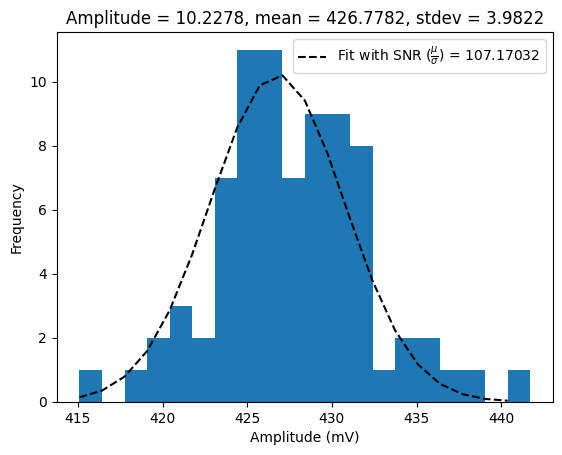

In [123]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Result logs for changing second stage gain

All results below are with # of bins = 20.

1. Baseline SNR is 107.17046 for R1 = 2000 $\Omega$ (offset 50%). 
2. SNR with R1 = 5000 $\Omega$ (offset = 43%) is 84.89963.

So the SNR got worse when we amplified the second stage gain. I also visually confirmed that the noise got amplified after the gain was increased; this indicates that the noise occurs *BEFORE* the second stage gain as well. 

Image here:
![here](IMG_5680.JPG)

The yellow cursors above show the average peak-to-peak noise level when we had the higher gain on. Once we reinstalled the 2000 $\Omega$ resistor, we see that the amplitude of the noise has also gone back down. This makes it very clear that the noise occured before the second stage gain. 

#### Changing the first stage gain

Now, to change the first stage gain, we note that 
$ G = \frac{C_{inj}}{C_{FB}} $.

We can change the first stage gain without having to change the $\tau$ of the preamp. To this end, we might replace the 1 pF with something like 5 pF to get a new gain of $ G = \frac{5}{0.5} = 10 $. If the noise is amplified as well, then we can conclude that the noise occurs before the first stage gain and after the function generator. 

We actually changed it to (an oversized) 10 pF capacitor, which results in a gain of $\frac{10}{0.5} = 20$. 

In [38]:
filename = "Feb14_Amp68mV_st025us_1ststagebaseline_dig2-usb22575_CH1_20240214140640-03.txt" # put file names here
file = open(filename, "r")
length = len(file.readlines())
file.close()

In [39]:
# Doing SNR using the peak noise method
peaks = []
waveforms = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
        waveforms.append(data)
    else:
        pass

peaks = np.array(peaks)
print(len(waveforms[0]))
print(len(peaks))

25000
79


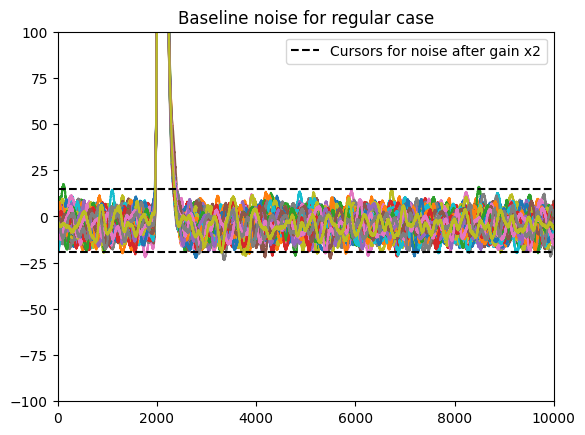

In [41]:
for wave in waveforms:
    plt.plot(wave)
plt.xlim(0, 10000)
plt.ylim(-100, 100)
plt.hlines(15, 0, 10000, color="black", ls="--", label="Cursors for noise after gain x2")
plt.hlines(-19, 0, 10000, color="black", ls="--")
plt.title("Baseline noise for regular case")
plt.legend()

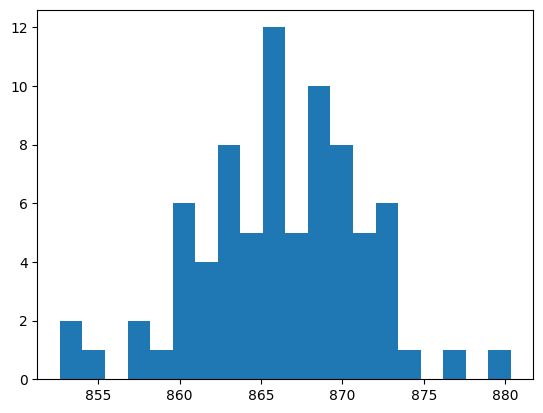

In [16]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [17]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[12, 865, 10])
print(popt)

[  8.86153125 865.97150083   4.81469075]


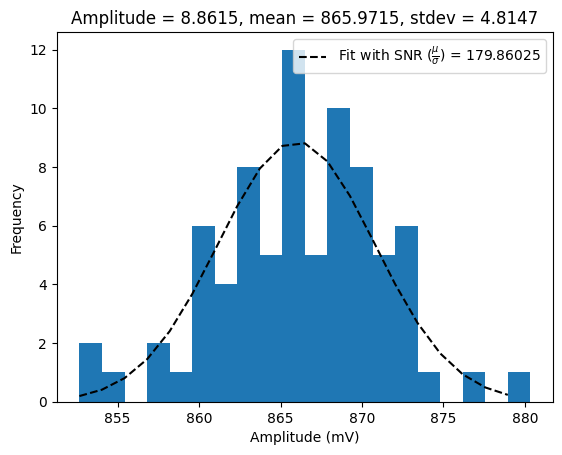

In [18]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Result logs for first stage gain
1. Baseline reading looks to have SNR ~ 86.70
2. With x2 gain, we see that the SNR has gone up to ~179.86

Hmm...it seems to be like we've improved our signal to noise ratio? The noise doesn't seem to be amplified even after the gain. 

So is the noise between the first stage and second stage?

#### A quick RMS study across our circuit, going upstream.

In [116]:
shaper_base = "Feb12_Amp68mV_st025us.txt_dig2-usb22575_CH1_20240212123702-13.txt"
shaper_gain = "Feb12_Amp68mV_st025us_shpgain.txt_dig2-usb22575_CH1_20240212124620-15.txt"
second_base = "Feb12_Amp68mV_st025us_2ndstagebaseline.txt_dig2-usb22575_CH1_20240212144230-20.txt"
second_gain = "Feb12_Amp68mV_st025us_2ndstagegainw5k_43offset.txt_dig2-usb22575_CH1_20240212151553-22.txt"
first_base = "Feb14_Amp68mV_st025us_1ststagebaseline_dig2-usb22575_CH1_20240214140640-03.txt"
first_gain = "Feb15_Amp68mV_st025us_1ststagegain2_dig2-usb22575_CH1_20240215111612-04.txt"
vd_base = "Feb15_Amp68mV_st025us_r1500r250_dig2-usb22575_CH1_20240215132347-27.txt"
bnc_base = "Feb15_Amp68mV_st025us_baselinewBNC_dig2-usb22575_CH1_20240215132714-29.txt"

In [122]:
# Finding length of desired file
filename = bnc_base # put file names here
file = open(filename, "r")
length = len(file.readlines())
file.close()

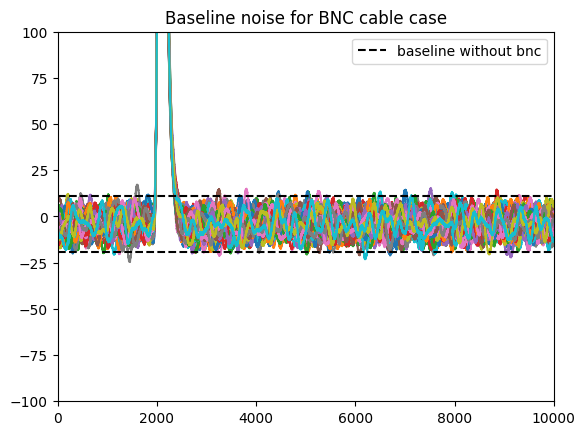

In [124]:
waveforms = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        waveforms.append(data)
    else:
        pass
for wave in waveforms:
    plt.plot(wave)
plt.xlim(0, 10000)
plt.ylim(-100, 100)
plt.hlines(11, 0, 10000, color="black", ls="--", label="baseline without bnc")
plt.hlines(-19, 0, 10000, color="black", ls="--")
plt.title("Baseline noise for BNC cable case")
plt.legend()

In [87]:
baseline = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        baseline.append(np.mean(data[4000:]))
    else:
        pass
print(baseline)

[-2.6409667619047625, -3.1403354285714284, -2.8395070000000002, -2.842691142857143, -2.759646571428571, -2.4092329047619048, -3.175524857142857, -2.801751952380952, -3.487854285714286, -2.7751450952380954, -3.185056619047619, -3.328991095238096, -3.3908390476190475, -3.675972619047619, -3.463658047619048, -2.9879497619047624, -4.3461424285714285, -4.822548952380952, -4.664812095238095, -4.420604428571428, -2.961244, -3.8406357619047617, -3.629959761904762, -3.879509761904762, -3.5928055238095236, -3.489475142857142, -4.310862952380953, -3.8059039523809526, -4.193051142857143, -3.844806, -4.155803904761905, -3.6715189523809526, -3.3265258571428573, -4.054352714285715, -3.860382761904762, -3.6729715238095237, -3.1993579523809528, -4.050107190476191, -4.374328809523809, -3.968990523809524, -3.3127633333333333, -4.176451380952381, -3.776154285714286, -3.3694741428571424, -4.020643904761904, -4.201627809523809, -3.8600993333333338, -3.663432380952382, -3.370294904761905, -4.001815095238095,

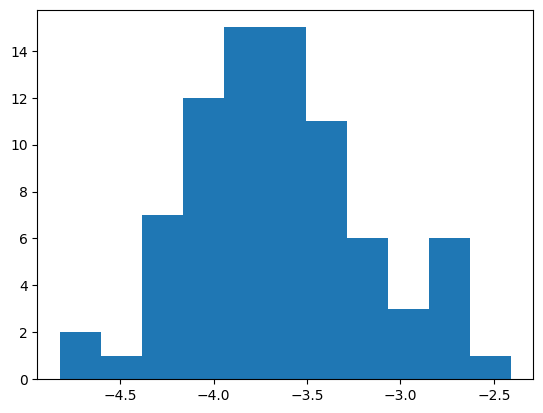

In [88]:
# Histogram for baseline
n, b, p = plt.hist(baseline, bins=11)


[15.17722159 -3.82880763  0.44081218]


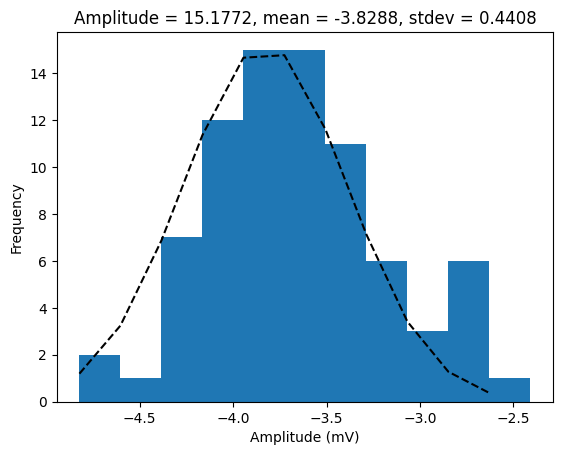

In [90]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[15, -3.8, 0.5])
print(popt)
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black")
n2, b2, p2 = plt.hist(baseline, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.show()

#### Changing the voltage divider
Now we look to see if the noise is before or after the divider. If it's before, then it must be some pickup noise from the cable (SMA currently). We could additionally switch that cable to BNC to check. 

In [9]:
filename = "Feb15_Amp68mV_st025us_r1255r250_dig2-usb22575_CH1_20240215125117-21.txt" # put file names here
file = open(filename, "r")
length = len(file.readlines())
file.close()

In [10]:
# Doing SNR using the peak noise method
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
    else:
        pass

peaks = np.array(peaks)
print(len(peaks))

80


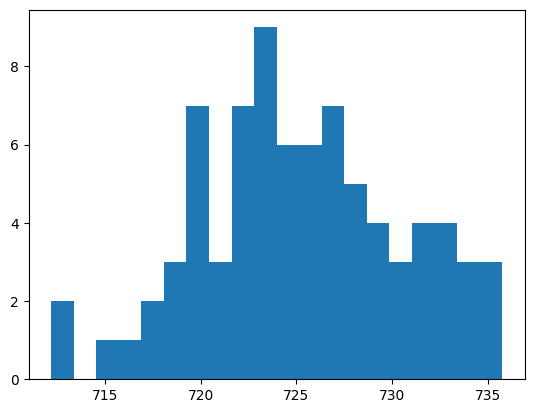

In [11]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [12]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[12, 725, 10])
print(popt)

[  6.69452904 724.60637823   5.86527512]


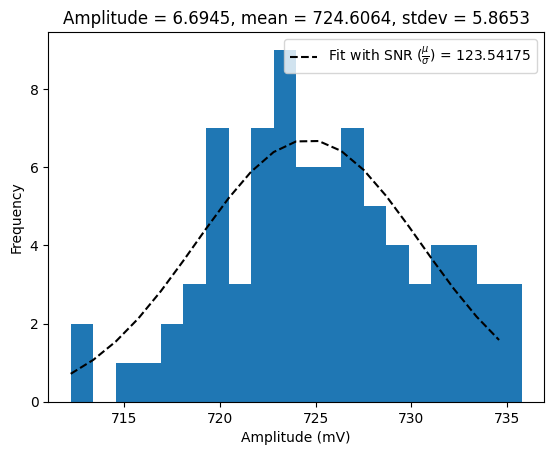

In [13]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Results for changing voltage divider values
1. SNR when R1 = 500 $\Omega$ and R2 = 50 $\Omega$: 80.67788
2. SNR when R1 = 255 $\Omega$ and R2 = 50 $\Omega$: 123.54175

#### Figuring out the energy conversion to estimate baseline noise

In [4]:
filename = "Feb12_Amp68mV_st025us.txt_dig2-usb22575_CH1_20240212123702-13.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

Peak value is 441.14 mV
Stdev: 5.08
Average noise FWHM (very rough) in mV = 11.95


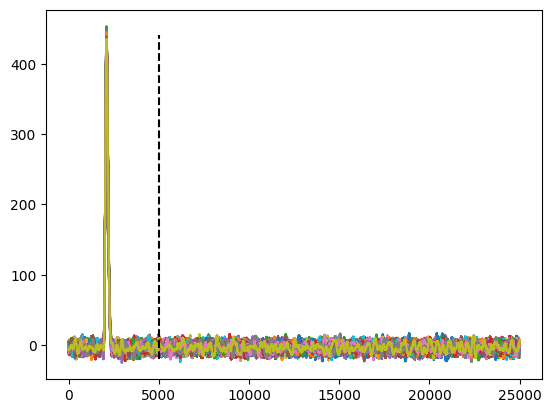

In [5]:
noise_list = []
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        noise = data[5000:]
        peak = max(data)
        noise_list.append(noise)
        peaks.append(peak)
        plt.plot(data)
    else:
        pass

noise_array = np.array(noise_list)
avg_noise_FWHM = 2.35*np.std(noise_array)
avg_stdev = np.std(noise_array)
print("Peak value is %.02f mV" % np.mean(peaks))
print("Stdev: %.02f" % (avg_stdev))
print("Average noise FWHM (very rough) in mV = %.02f" % avg_noise_FWHM)


plt.vlines(5000, -20, 441.14, color="black", ls="--")
plt.show()

In [8]:
conv_factor = 0.9659/np.mean(peaks) # units are MeV/mV
print("Average noise is around %.04f keV" % (abs(avg_noise_FWHM)*conv_factor*1e3))

Average noise is around 26.1578 keV


#### Reasoning

Assuming that the baseline noise mostly fluctuates as much above zero as it does below zero (no DC offset), we can take the abs() of the mean of the noise present in all the traces.

This came out to be -3.93 mV, which I took the abs() of to get 3.93 mV of average noise. 

The formula for converting from voltage to energy is given below.

$ A (eV) = C_{inj}*\frac{V_{FG}}{11}*\frac{1}{1.6*10^{-19}}*25$

where $C_{inj} = 1 pF, V_{FG} = 68 mV$.

With an input signal with amplitude 68 mV, we use the above formula to see that an analogous particle would deposit 0.9569 MeV in our detector.

We assert that the peak height of our signal in the traces is equal to this deposited energy $E_{dep}$ to get a conversion factor between voltage and energy units.

In this case, we get the following setup:

$441.14 mV = 0.9569 MeV \rightarrow 1 mV = \frac{0.9569}{441.14} MeV$

With our average noise measured to be around 3.93 mV, we get a baseline noise level of 8.6136 keV in this study. This means that, theoretically, a sub-10 keV resolution is possible. 

I will collect more baseline data and recreate the FWHM vs. shaping time graph when the CAEN becomes available to corroborate this theory.

#### Additional notes to reasoning

I created an array to store all the baseline noise from all 79-80 something traces. Then, I took np.std() of that array and multiplied by 2.35 to get the FWHM of the noise distribution array. Then, I converted that from mV $\rightarrow$ MeV/keV and found it to be 26.158 keV. This is with the pure baseline settings. I'm now going to analyze the noise level of a better case.

Peak value is 973.64 mV
Stdev: 5.14
Average noise FWHM (very rough) in mV = 12.09


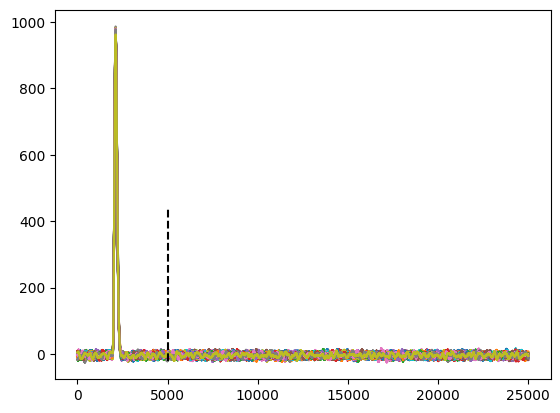

In [21]:
# Analyzing the baseline noise when signal is amplified on the signal generator side.

filename = "Feb12_Amp147mV_st025us.txt_dig2-usb22575_CH1_20240212123313-11.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

noise_list = []
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        noise = data[5000:]
        peak = max(data)
        noise_list.append(noise)
        peaks.append(peak)
        plt.plot(data)
    else:
        pass


noise_array = np.array(noise_list)
avg_noise_FWHM = 2.35*np.std(noise_array)
avg_stdev = np.std(noise_array)
print("Peak value is %.02f mV" % np.mean(peaks))
print("Stdev: %.02f" % (avg_stdev))
print("Average noise FWHM (very rough) in mV = %.02f" % avg_noise_FWHM)


plt.vlines(5000, -20, 441.14, color="black", ls="--")
plt.show()

In [23]:
amp = 147e-3
energy_of_sq = 1e-12 * amp/11 * 25/(1.6e-19) * 1e-6
conv_factor = energy_of_sq/np.mean(peaks) # units are MeV/mV
print("Average noise is around %.04f keV" % (abs(avg_noise_FWHM)*conv_factor*1e3))

Average noise is around 25.9271 keV


Peak value is 866.18 mV
Stdev: 5.33
Average noise FWHM (very rough) in mV = 12.54


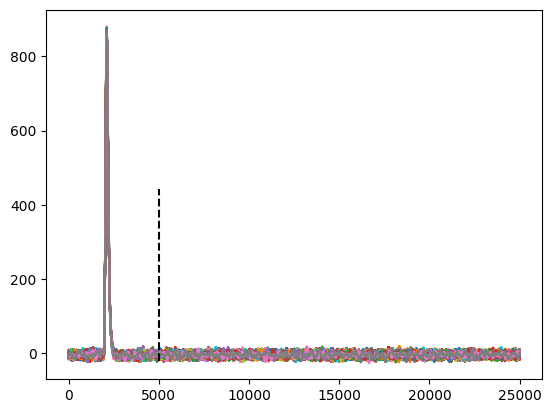

In [30]:
# Analyzing the baseline noise when signal is amplified at the first stage.

filename = "Feb15_Amp68mV_st025us_1ststagegain2_dig2-usb22575_CH1_20240215111612-04.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

noise_list = []
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        noise = data[5000:]
        peak = max(data)
        noise_list.append(noise)
        peaks.append(peak)
        plt.plot(data)
    else:
        pass


noise_array = np.array(noise_list)
avg_noise_FWHM = 2.35*np.std(noise_array)
avg_stdev = np.std(noise_array)
print("Peak value is %.02f mV" % np.mean(peaks))
print("Stdev: %.02f" % (avg_stdev))
print("Average noise FWHM (very rough) in mV = %.02f" % avg_noise_FWHM)


plt.vlines(5000, -20, 441.14, color="black", ls="--")
plt.show()

In [34]:
amp = 68e-3
energy_of_sq = 2e-12 * amp/11 * 25/(1.6e-19) * 1e-6
conv_factor = energy_of_sq/np.mean(peaks) # units are MeV/mV
print("Average noise is around %.04f keV" % (abs(avg_noise_FWHM)*conv_factor*1e3))

Average noise is around 27.9588 keV


Peak value is 725.34 mV
Stdev: 5.36
Average noise FWHM (very rough) in mV = 12.60


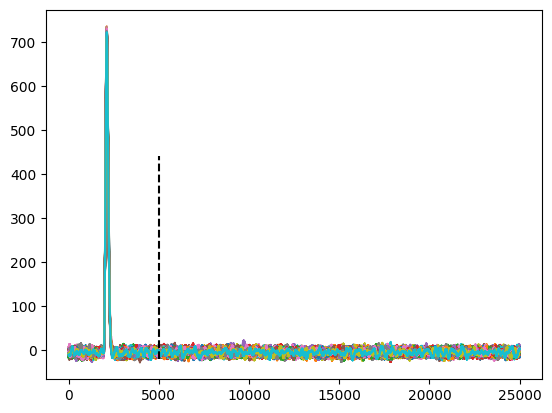

In [41]:
# Analyzing the baseline noise when voltage divider was modified.

filename = "Feb15_Amp68mV_st025us_r1255r250_dig2-usb22575_CH1_20240215125117-21.txt"
file = open(filename, "r")
length = len(file.readlines())
file.close()

noise_list = []
peaks = []
for num in range(1, length):
    if num % 5 == 0:
        data = np.loadtxt(filename, skiprows=num-1, max_rows=1)
        noise = data[5000:]
        peak = max(data)
        noise_list.append(noise)
        peaks.append(peak)
        plt.plot(data)
    else:
        pass


noise_array = np.array(noise_list)
avg_noise_FWHM = 2.35*np.std(noise_array)
avg_stdev = np.std(noise_array)
print("Peak value is %.02f mV" % np.mean(peaks))
print("Stdev: %.02f" % (avg_stdev))
print("Average noise FWHM (very rough) in mV = %.02f" % avg_noise_FWHM)


plt.vlines(5000, -20, 441.14, color="black", ls="--")
plt.show()

In [42]:
amp = 68e-3
energy_of_sq = 1e-12 * 10*amp/61 * 25/(1.6e-19) * 1e-6
conv_factor = energy_of_sq/np.mean(peaks) # units are MeV/mV
print("Average noise is around %.04f keV" % (abs(avg_noise_FWHM)*conv_factor*1e3))

Average noise is around 30.2638 keV


#### Comparison between 6 $\mu s$ shaping time and 0.25 $\mu s$ shaping time

In [45]:
baseline_6 = "noise analysis 26_2_24 by robin/Feb26_Amp68mV_st6us_fullbaseline_dig2-usb22575_CH1_20240226115153-11.txt"
baseline_025 = "noise analysis 26_2_24 by robin/Feb26_Amp68mV_st025us_fullbaseline_dig2-usb22575_CH1_20240226124010-35.txt"

In [70]:
filenames = [baseline_6, baseline_025]
lengths = []
for name in filenames:
    file = open(name, "r")
    length = len(file.readlines())
    lengths.append(length)
    file.close()

In [71]:
# Making SNR plots
ind = 1
peaks = []
for num in range(1, lengths[ind]):
    if num % 5 == 0:
        data = np.loadtxt(filenames[ind], skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
    else:
        pass

peaks = np.array(peaks)
print(len(peaks))

58


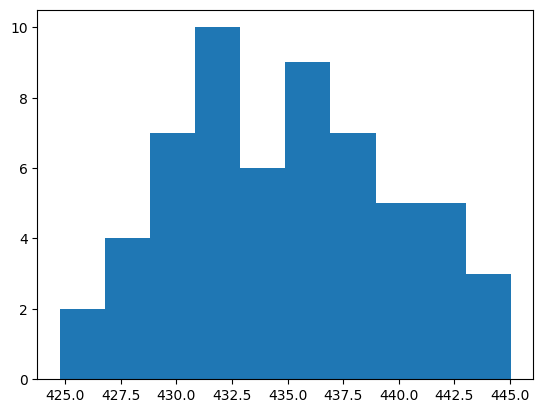

In [72]:
val = 10
n, b, p = plt.hist(peaks, bins=val)

In [49]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[5, 435, 3])
print(popt)

[  4.30524669 433.97309198   5.94307999]


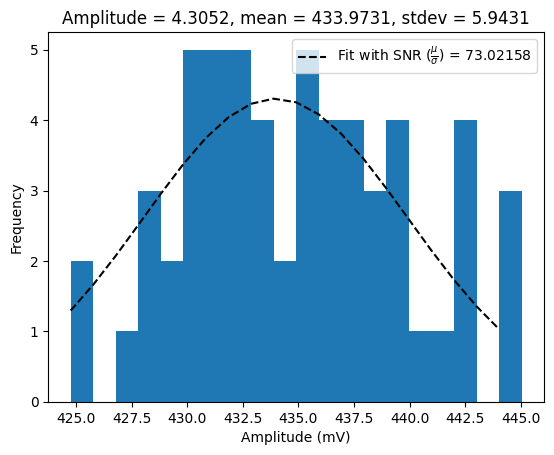

In [50]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Peak value is 389.34 mV
Stdev: 1.18
Average noise FWHM (very rough) in mV = 2.76


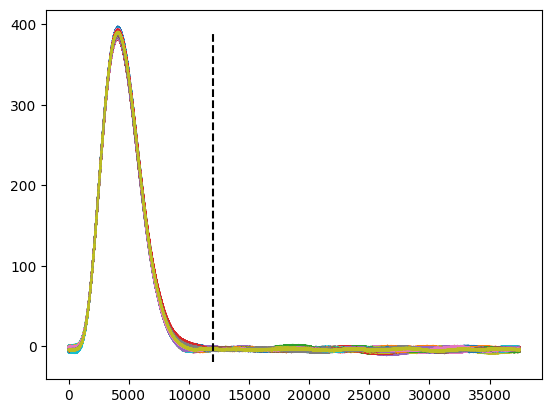

In [28]:
noise_list = []
peaks = []
start_of_noise = 12000
ind = 0

for num in range(1, lengths[ind]):
    if num % 5 == 0:
        data = np.loadtxt(filenames[ind], skiprows=num-1, max_rows=1)
        noise = data[start_of_noise:]
        peak = max(data)
        noise_list.append(noise)
        peaks.append(peak)
        plt.plot(data)
    else:
        pass


noise_array = np.array(noise_list)
avg_noise_FWHM = 2.35*np.std(noise_array)
avg_stdev = np.std(noise_array)
print("Peak value is %.02f mV" % np.mean(peaks))
print("Stdev: %.02f" % (avg_stdev))
print("Average noise FWHM (very rough) in mV = %.02f" % avg_noise_FWHM)


plt.vlines(start_of_noise, -20, np.mean(peaks), color="black", ls="--")
plt.show()

In [29]:
amp = 68e-3
energy_of_sq = 1e-12 * amp/11 * 25/(1.6e-19) * 1e-6
conv_factor = energy_of_sq/np.mean(peaks) # units are MeV/mV
print("Average noise is around %.04f keV" % (abs(avg_noise_FWHM)*conv_factor*1e3))

Average noise is around 6.8593 keV


##### Results from SNR study

1. SNR for 6 $\mu s$ baseline = 147.214
2. SNR for 0.25 $\mu s$ baseline = 73.022

### Noise in energy units
1. For 0.25 $\mu s$, we see a baseline noise level of 26.92 keV
2. For 6 $\mu s$, we see a baseline noise level of 6.86 keV


I'm going to try and collect data for a full FWHM vs. shaping time curve to try and verify this seemingly crazy result.

In [136]:
st025 = "FWHM vs shaping time data/Feb26_Amp68mV_st025us_dig2-usb22575_CH1_20240226131300-43.txt"
st1 = "FWHM vs shaping time data/Feb26_Amp68mV_st1us_dig2-usb22575_CH1_20240226132844-53.txt"
st15 = "FWHM vs shaping time data/Feb26_Amp68mV_st15us_dig2-usb22575_CH1_20240226133444-57.txt"
st4 = "FWHM vs shaping time data/Feb26_Amp68mV_st4us_dig2-usb22575_CH1_20240226134008-60.txt"
st5 = "FWHM vs shaping time data/Feb26_Amp68mV_st5us_dig2-usb22575_CH1_20240226134610-63.txt"
st6 = "FWHM vs shaping time data/Feb26_Amp68mV_st6us_dig2-usb22575_CH1_20240226144930-71.txt"

In [158]:
filenames = [st025, st1, st15, st4, st5, st6]
lengths = []

for name in filenames:
    file = open(name, "r")
    length = len(file.readlines())
    lengths.append(length)
    file.close()
    

In [159]:
# Making peak noise histograms and extracting the FWHM to use in the plot
ind = 0
peaks = []
for num in range(1, lengths[ind]):
    if num % 5 == 0:
        data = np.loadtxt(filenames[ind], skiprows=num-1, max_rows=1)
        peak = max(data)
        peaks.append(peak)
    else:
        pass

peaks = np.array(peaks)
print(len(peaks))

178


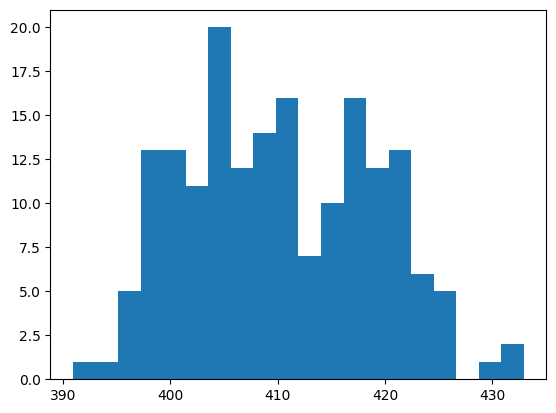

In [160]:
val = 20
n, b, p = plt.hist(peaks, bins=val)

In [133]:
popt, pcov = curve_fit(Gauss, b[0:len(n)], n, p0=[25, 492, 5])
print(popt)

[ 20.96543758 489.71930055   2.92399693]


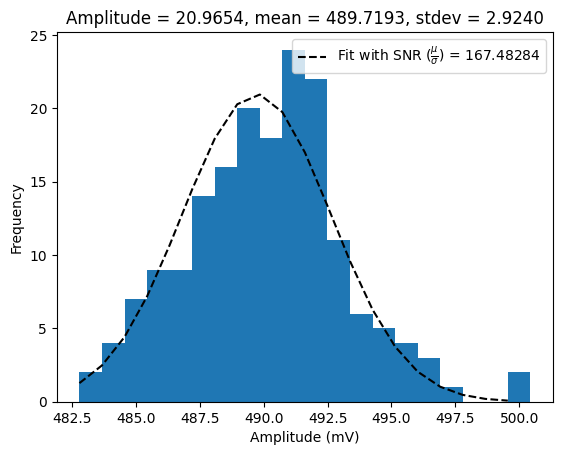

In [134]:
plt.plot(b[0:len(n)], Gauss(b[0:len(n)], *popt), "--", color="black", label=r"Fit with SNR ($\frac{\mu}{\sigma}$) = %.05f" % (popt[1]/popt[2]))
n2, b2, p2 = plt.hist(peaks, bins=b)
plt.title("Amplitude = %.04f, mean = %.04f, stdev = %.04f" % (popt[0], popt[1], popt[2]))
plt.xlabel("Amplitude (mV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [135]:
amp = 68e-3
energy_of_sq = 1e-12 * amp/11 * 25/(1.6e-19) * 1e-6
conv_factor = energy_of_sq/np.mean(peaks) # units are MeV/mV
print(popt[2]*2.35*conv_factor*1e3)

13.543074371299694


#### Results:
1. For shaping time $0.25 \mu s$, 
    - SNR = 38.57 (why? the only difference is an increase in # of traces)
    - FWHM (in keV) = 58.59
2. For shaping time $1 \mu s$,
    - SNR = 125.16
    - FWHM (in keV) = 18.12
3. For shaping time $1.5 \mu s$,
    - SNR = 135.86
    - FWHM (in keV) = 16.69
4. For shaping time $4 \mu s$,
    - SNR = 183.34
    - FWHM (in keV) = 12.37
5. For shaping time $5 \mu s$,
    - SNR = 192.05
    - FWHM (in keV) = 11.81
6. For shaping time $6 \mu s$ *AFTER SHAPER CHANGED WAVEFORM*,
    - SNR = 167.48
    - FWHM (in keV) = 13.54

#### Comments:
1. I noticed an issue with the shaper that concerns me. When adjusting the pole-zero correction screw, if my hand nudges the multiplier button next to it, it changes the waveform drastically. I'm not sure why this happens, but it definitely affects the results. 

This changes the peak height and then the conversion factor. However, it seems to be the case that we see a downward trend in the FWHM even with this change.

#### Same analysis as above but with the noise baseline to corroborate the above result

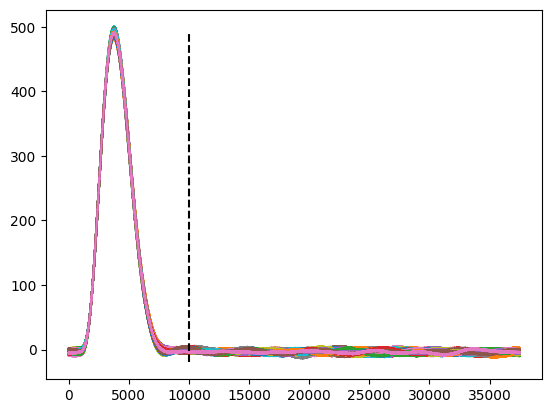

In [156]:
# Making baseline noise histograms and extracting the FWHM to use in the plot
ind = 5
noise_list = []
peaks = []
start_of_noise = 10000

for num in range(1, lengths[ind]):
    if num % 5 == 0:
        data = np.loadtxt(filenames[ind], skiprows=num-1, max_rows=1)
        peak = max(data)
        noise = data[start_of_noise:]
        peaks.append(peak)
        noise_list.append(noise)
        plt.plot(data)
    else:
        pass

plt.vlines(start_of_noise, -20, np.mean(peaks), color='black', ls="--")
plt.show()

In [157]:
noise_array = np.array(noise_list)
noise_stdev = np.std(noise_array)
noise_FWHM = noise_stdev*2.35

print("The FWHM of the baseline noise is about %.02f mV" % noise_FWHM)

amp = 68e-3
energy_of_sq = 1e-12 * amp/11 * 25/(1.6e-19) * 1e-6
conv_factor = energy_of_sq/np.mean(peaks) # units are MeV/mV
print("The FWHM of the baseline noise in energy units is %.02f keV" % (noise_FWHM*conv_factor*1e3))

The FWHM of the baseline noise is about 4.63 mV
The FWHM of the baseline noise in energy units is 9.13 keV


#### Results:
1. For shaping time $0.25 \mu s$, 
    - FWHM (in keV) = 26.95
2. For shaping time $1 \mu s$,
    - FWHM (in keV) = 17.59
3. For shaping time $1.5 \mu s$,
    - FWHM (in keV) = 14.20
4. For shaping time $4 \mu s$,
    - FWHM (in keV) = 10.94
5. For shaping time $5 \mu s$,
    - FWHM (in keV) = 9.47
6. For shaping time $6 \mu s$ *AFTER SHAPER CHANGED WAVEFORM*,
    - FWHM (in keV) = 9.13

#### Comments:
1. So this makes sense...we always have an energy resolution that is bounded below by our baseline noise. This helps as a sanity check.
2. Why do we have such a huge variation with the peak heights then? 